## Import thư viện

In [170]:
# !pip install -r requirements.txt

In [171]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch.autograd.functional import jacobian
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

## Khởi chạy mô hình

In [172]:
model = models.vgg16(pretrained=True)
model.eval()

/Users/quytrungg/.pyenv/versions/3.10.12/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/quytrungg/.pyenv/versions/3.10.12/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Hàm đọc file và chuyển thành input tensor

In [173]:
def input_link(name):
    img = Image.open(name).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    return img_tensor.unsqueeze(0)

## Predict kết quả bằng torch

In [174]:
def predict_decode(yhat):
    probabilities = torch.softmax(yhat, dim=1)
    top5_prob_indices = torch.topk(probabilities, 5)[1].squeeze(0).tolist()
    
    with open("labels.txt") as f:
        labels = [line.strip() for line in f.readlines()]
    
    top5_labels = [(labels[i], probabilities[0, i].item()) for i in top5_prob_indices]
    for i in top5_labels:
        print(i)
    return (top5_labels[0], int(yhat.argmax()))

In [175]:
image_tensor = input_link("./test.jpeg")
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [176]:
yhat = model(image_tensor)
result = predict_decode(yhat)

('brown bear', 0.9943759441375732)
('American black bear', 0.005614399444311857)
('sloth bear', 9.075087291421369e-06)
('wombat', 6.342694973682228e-07)
('ice bear', 1.1953853018553673e-08)


In [177]:
label = result[1]
label

294

## Hàm map input đến layer bất kì trong model

In [178]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        # x = torch.relu(x)  # Applying ReLU activation function
        return x

def map2layer(x, start, end, model=model):
    new_model = torch.nn.Sequential(*(list(model.children())[0] + torch.nn.Sequential(model.avgpool) + torch.nn.Sequential(Flatten()) + list(model.children())[2]))
    layers = torch.nn.Sequential(*(list(new_model.children())[start:end]))
    layers.eval()
    output = layers(x)
    return output

## Hàm dùng để kết nối các phần trong mô hình bằng lớp Flatten

In [179]:
def generate_flat_model(model=model):
    new_model = torch.nn.Sequential(*(list(model.children())[0] + torch.nn.Sequential(model.avgpool) + torch.nn.Sequential(Flatten()) + list(model.children())[2]))
    layers = torch.nn.Sequential(*(list(new_model.children())))
    return layers

# Các helper method

In [203]:
def jacobian_gradient(input, layer_idx, model=model):
    activation_map = map2layer(input, 0, layer_idx)
    activation_map.requires_grad_(True)
    second_last_layers = map2layer(activation_map, layer_idx+1, -2)
    num_outputs = second_last_layers.shape[1]
    grads = []
    for i in range(num_outputs):
        print(i)
        grad_output = torch.zeros_like(second_last_layers)
        grad_output[:, i] = 1
        grad = torch.autograd.grad(second_last_layers, activation_map,
            grad_outputs=grad_output, retain_graph=True)[0]
        grads.append(grad.unsqueeze(1))
    grads = torch.cat(grads, dim=1)
    return activation_map, grads

def nearest_neighboor(input, model, labels):
    # out = torch.sigmoid(map2layer(input, 0, -2, model))
    out = map2layer(input, 0, -2, model)
    print(out.shape, labels.shape)
    d = torch.sum((out - labels) ** 2, dim=-1)
    return d.argsort()

def similar_neurons_activation(in1, in2, threshold=0.5):
    sim = (in1 > threshold) & (in2 > threshold)
    neuron_id = torch.arange(4096)[sim]
    neuron_id = neuron_id[(torch.abs(in1 - in2).detach().numpy()[neuron_id]).argsort()]
    return neuron_id

def overlayCAM(heatmap, origin_img_path, image_tensor):
    img = cv2.imread(origin_img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = heatmap / np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    print(heatmap.shape, img.shape)
    plt.imshow(image_tensor.permute(0, 2, 3, 1)[0].numpy())
    plt.imshow(heatmap,cmap='seismic',alpha=0.6)

# Hàm đọc kết quả lớp cuối của bộ dữ liệu (tensorflow), cần tạo lại bộ data này bên torch

In [181]:
with open('saved_dictionary.pkl', 'rb') as f:
    last_layer = pickle.load(f)
labels = []
for layer in last_layer.values():
    labels.extend(layer)
labels = torch.stack([torch.tensor(arr) for arr in labels])
# labels = torch.sigmoid(labels)

In [182]:
neighbors = nearest_neighboor(image_tensor, model, labels)
neighbors

torch.Size([1, 4096]) torch.Size([50000, 4096])


tensor([21221, 49017, 46629,  ...,  4353, 31459,  7252])

## Tensorflow

In [183]:
def cal_grads(input, mask):
    s_in = map2layer(input,-5)
    with tf.GradientTape() as tape:
        tape.watch(s_in)
        out = tf.keras.Model(model.layers[-4].input,model.layers[-2].output)(s_in)[0] *  np.array(mask)
    grad = tape.gradient(out,s_in)
    return grad,tf.cast(
        tf.reduce_sum(tf.cast(s_in>0,float), axis=(0,1,2)) > 0,
        float,
    ) * tf.reduce_sum(grad,axis = (0,1,2)) / (tf.reduce_sum( tf.cast(s_in>0,float), axis=(0,1,2)) + 1e-16)

In [184]:
# grad4, w4 = cal_grads(input_idx(0),tf.ones(4096))
# overlayCAM(
#     tf.reduce_mean(map2layer(input_idx(0),-5) * tf.nn.relu(w4)[tf.newaxis,tf.newaxis,tf.newaxis],axis = (0,-1)).numpy(),
#     image_dir(0),
# )

## Pytorch

### Hàm calculate gradients trong torch

In [193]:
def cal_grads_torch(input_tensor, mask):
    s_in = map2layer(input_tensor, 0, -9)
    out = map2layer(s_in, -8, -2)[0] * mask
    out = out.sum()
    grad = torch.autograd.grad(out, s_in)[0]
    s_in_activate = torch.sum((s_in > 0).float(), dim=(0, 2, 3))
    print((s_in_activate > 0).float().shape)
    return grad, (s_in_activate > 0).float() * torch.sum(grad, dim=(0, 2, 3)) / (s_in_activate + 1e-16)

In [194]:
grad, w4 = cal_grads_torch(image_tensor, torch.ones(4096))

torch.Size([512])


In [187]:
grad.shape, w4.shape

(torch.Size([1, 512, 7, 7]), torch.Size([512]))

### Hoán vị ma trận để có shape giống với shape bên tensorflow (do tensorflow size là [1, 7, 7, 512] còn torch là [1, 512, 7, 7])

In [188]:
map2layer(image_tensor, 0, -9).permute(0, 2, 3, 1).shape, w4.view(1, 1, 1, 512).shape

(torch.Size([1, 7, 7, 512]), torch.Size([1, 1, 1, 512]))

### Nhân 2 ma trận với nhau rồi đưa về size torch gốc

In [189]:
map2layer(image_tensor, 0, -9).shape

torch.Size([1, 512, 7, 7])

In [190]:
map2layer(image_tensor, 0, -9).shape

torch.Size([1, 512, 7, 7])

In [195]:
b = map2layer(image_tensor, 0, -9).permute(0,3,2,1) * w4.view(1,1,1,512)
b = b.permute(0, 3, 2, 1)
b.shape

torch.Size([1, 512, 7, 7])

### Nhưng mà kết quả ra hơi lạ, cíu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224) (224, 224, 3)


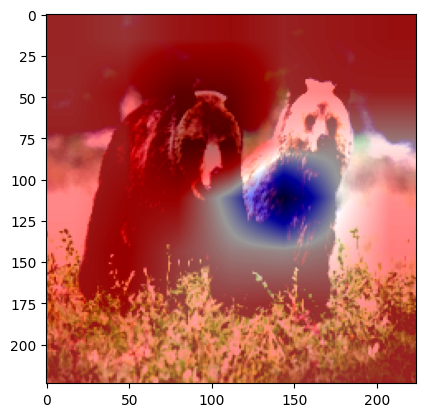

In [215]:
overlayCAM(
    torch.mean(b[0], dim=(0)).detach().numpy(),
    "./test.jpeg",
    image_tensor,
)